## TO DO:

- SHAP Values use? why only 5 interactions? 
- Classification report, confusion matrix interpretation
- Other evaluation metrics?
- Add comments and/or tables to main report?
- Combine customer comments from other file .. for Sentiment analysis

## Data Load & Characteristics

- Load data and look at its characteristics

### Libraries & Functions


In [20]:
# Libraries
#

import os

import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, zero_one_loss, confusion_matrix
import shap

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns


In [2]:
# Establish valid data file path, for reading and saving eg CSV files
#

import os
data_directory = 'Data_Sources'          # Designated data folder above the current working directory
project_directory = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(project_directory, data_directory)
if not os.path.isdir(DATA_PATH):
    raise Exception(f'Directory not found: {DATA_PATH}')

del data_directory, project_directory

In [3]:
# A simple utility function to obtain and summarise key elements of a given dataframe

def print_file_summary(data_frame):
    # Create a temporary df and ensure no lists remain, so that unique items can be identified for uniqueness
    temp_df = data_frame.copy()
    temp_df = temp_df.map(lambda cell: str(cell) if isinstance(cell, list) else cell)
    
    # Calculate Data Types 
    summary_of_df = pd.DataFrame({'Count': data_frame.count(),
                                 'Missing': data_frame.isnull().sum(), 'Empty': 0,
                                 'Unique': temp_df.nunique(),
                                 'Type': data_frame.dtypes, 
                                 'String': 0, 'Int': 0, 'Float': 0, 'List': 0
                                 })
    summary_of_df['Empty'] = (data_frame == '').sum()
    summary_of_df['String'] = data_frame.map(lambda cell: isinstance(cell, str)).sum()
    summary_of_df['Int'] = data_frame.map(lambda cell: isinstance(cell, int)).sum()
    summary_of_df['Float'] = data_frame.map(lambda cell: isinstance(cell, float)).sum()
    summary_of_df['List'] = data_frame.map(lambda cell: isinstance(cell, list)).sum()

    display(summary_of_df)

### Characteristics


In [14]:
# Load Source CSV files

file_name = 'hotel_reviews.csv'
file_path = os.path.join(DATA_PATH, file_name)
if not os.path.isfile(file_path):
    raise Exception(f'File not found: {file_path}')

hotel_reviews_df = pd.read_csv(file_path)

# Convert categorical values for XGBoost
categorical_columns = ['gender', 'purpose_of_travel','type_of_travel', 'type_of_booking']
for next_col in categorical_columns:
    hotel_reviews_df[next_col] = hotel_reviews_df[next_col].astype('category')

# Tidy Up
del file_name, file_path, categorical_columns, next_col

In [15]:
#| label: csv_file_types

print_file_summary(hotel_reviews_df)

,Count,Missing,Empty,Unique,Type,String,Int,Float,List
id,103904,0,0,103904,int64,0,103904,0,0
gender,103904,0,0,2,category,103904,0,0,0
age,103904,0,0,75,int64,0,103904,0,0
purpose_of_travel,103904,0,0,5,category,103904,0,0,0
type_of_travel,103904,0,0,2,category,103904,0,0,0
type_of_booking,103904,0,0,3,category,103904,0,0,0
score_wifi,103904,0,0,5,int64,0,103904,0,0
score_transport,103904,0,0,5,int64,0,103904,0,0
score_booking,103904,0,0,5,int64,0,103904,0,0
score_location,103904,0,0,5,int64,0,103904,0,0


In [11]:
#| label: csv_file_summary

print(hotel_reviews_df.head(3))

       id  gender  age purpose_of_travel   type_of_travel type_of_booking  \
0   70172    Male   13          aviation  Personal Travel     Not defined   
1    5047    Male   25           tourism     Group Travel  Group bookings   
2  110028  Female   26           tourism     Group Travel  Group bookings   

   score_wifi  score_transport  score_booking  score_location  \
0           2                3              2               1   
1           2                2              2               2   
2           2                2              2               2   

   score_restaurant  score_staff  score_parking  score_checkin  \
0                 4            4              4              3   
1                 1            1              1              1   
2                 4            4              4              3   

   score_local_sites  score_housekeeping  score_overall  
0                  4                   4              1  
1                  3                   1         

In [12]:
#| label: csv_file_stats

print(hotel_reviews_df.describe())

                  id            age     score_wifi  score_transport  \
count  103904.000000  103904.000000  103904.000000    103904.000000   
mean    64924.210502      39.379706       2.179839         2.425912   
std     37463.812252      15.114964       0.943846         1.131421   
min         1.000000       7.000000       0.000000         0.000000   
25%     32533.750000      27.000000       2.000000         2.000000   
50%     64856.500000      40.000000       2.000000         2.000000   
75%     97368.250000      51.000000       3.000000         3.000000   
max    129880.000000      85.000000       4.000000         4.000000   

       score_booking  score_location  score_restaurant    score_staff  \
count  103904.000000   103904.000000     103904.000000  103904.000000   
mean        2.199935        2.333192          2.538324       2.698991   
std         1.011443        0.909634          0.965042       0.975912   
min         0.000000        0.000000          0.000000       0.00000

## XGBoost Model Creation & Forecasting


### Create the XGBoost Model

In [16]:
# XGBoost Model Training

# Split the data into features X and target Y which is the customer satisfaction score

X = hotel_reviews_df.drop(columns=['id', 'score_overall'])
y = hotel_reviews_df['score_overall']

# Split the data randomly with 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model & fit to the data
model = xgb.XGBClassifier(enable_categorical=True)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Evaluate The XGBoost Model



              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2142
           1       0.47      0.42      0.45      4894
           2       0.45      0.51      0.48      4677
           3       0.48      0.49      0.48      4545
           4       0.46      0.44      0.45      4523

    accuracy                           0.52     20781
   macro avg       0.56      0.57      0.57     20781
weighted avg       0.52      0.52      0.52     20781

Classification Error: 0.48


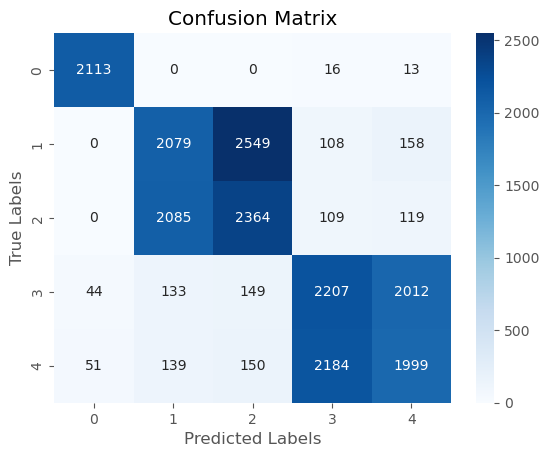

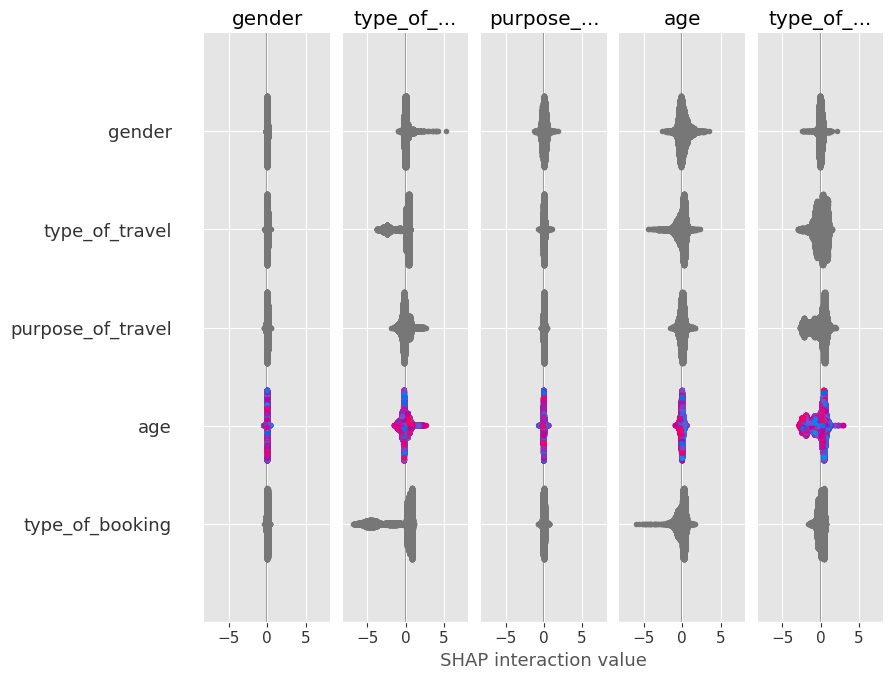

In [21]:
# Model Evaluation

# Predictions
y_predictions = model.predict(X_test)

# Classification report & accuracy score & Classification error
print(classification_report(y_test, y_predictions))
error = zero_one_loss(y_test, y_predictions)
print(f"Classification Error: {error:.2f}")

# Calculate and visualise the confusion matrix
cm = confusion_matrix(y_test, y_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# SHAP Feature importance
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


### Using the XGBoost Model


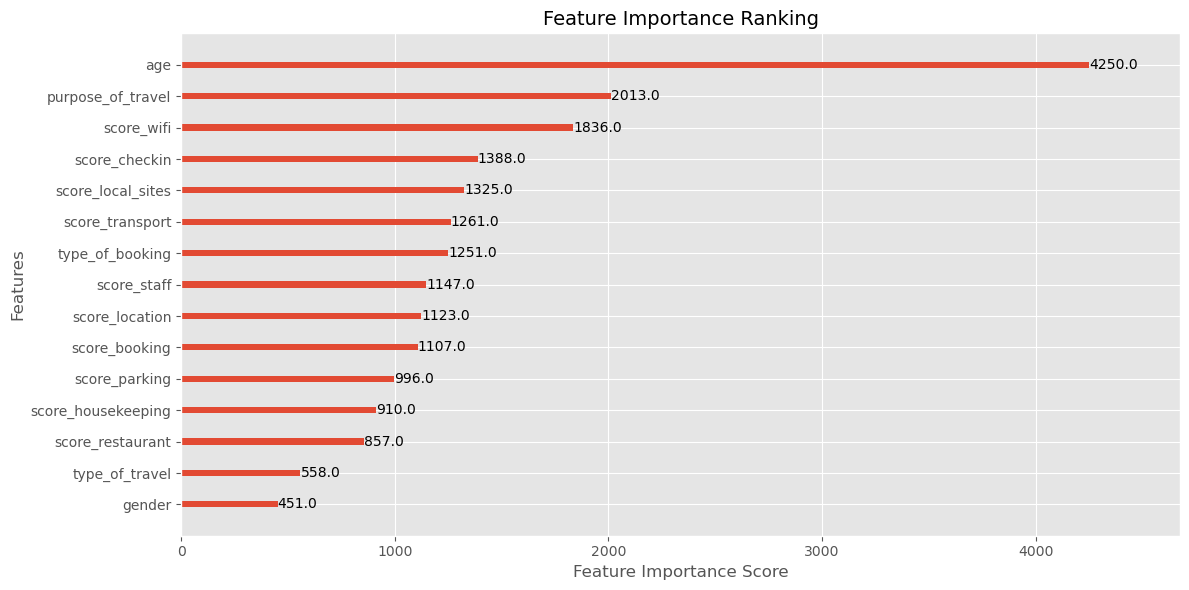

In [36]:
#| label: feature-importance
#| fig-cap: XGBoost Feature Importance Results

# Identify Current Feature Importance
#

# Plot the features by importance
fig, ax1 = plt.subplots(figsize=(12, 6))
xgb.plot_importance(model, ax=ax1)

ax1.set_title(f'Feature Importance Ranking', fontsize=14)
ax1.set_xlabel('Feature Importance Score', fontsize=12)
ax1.set_ylabel('Features', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
# Calculate and plot an I-S Model
